In [1]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [3]:
n = 345 #novel number
t = 'Dracula' #novel name
s = 1 #how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [4]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [5]:
for l in range(2):
    novelWriter = csv.writer(open('data/novel_'+novel_title+'.csv', 'w'), delimiter=',')
    for sentence in novel_sentences:
        novelWriter.writerow([sentence])

Read in the csv file to pandas

In [6]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [7]:
df_novel.head()

,0
0,"Bistritz._--Left Munich at 8:35 P. M., on 1st ..."
1,"Buda-Pesth seems a wonderful place, from the g..."
2,"I feared to go very far from the station, as w..."
3,The impression I had was that we were leaving ...
4,"We left in pretty good time, and came after ni..."


Create the wrd_length and total_char columns.

In [8]:
wrd_length = []
total_char = []
def wrd_char_counts(sentence):
    total_chars = 0
    wrd_counts = []
    for word in sentence:
        char_count = len(word)
        wrd_counts.append(char_count)
        total_chars += char_count
    total_char.append(total_chars)
    wrd_length.append(wrd_counts)

In [9]:
for l in df_novel[0]:
    sent = TextBlob(l)
    wrd_char_counts(sent.words)

In [10]:
df_novel['wrd_length'] = wrd_length
df_novel['total_char'] = total_char

In [11]:
df_novel.head()

,0,wrd_length,total_char
0,"Bistritz._--Left Munich at 8:35 P. M., on 1st ...","[8, 4, 6, 2, 4, 1, 1, 2, 3, 3, 8, 2, 6, 5, 4, ...",110
1,"Buda-Pesth seems a wonderful place, from the g...","[10, 5, 1, 9, 5, 4, 3, 7, 5, 1, 3, 2, 2, 4, 3,...",108
2,"I feared to go very far from the station, as w...","[1, 6, 2, 2, 4, 3, 4, 3, 7, 2, 2, 3, 7, 4, 3, ...",93
3,The impression I had was that we were leaving ...,"[3, 10, 1, 3, 3, 4, 2, 4, 7, 3, 4, 3, 8, 3, 4,...",174
4,"We left in pretty good time, and came after ni...","[2, 4, 2, 6, 4, 4, 3, 4, 5, 9, 2, 12]",57


Create syllable count column

In [12]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [13]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [14]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [15]:
df_novel['syl_count'] = syl_count_arr

In [16]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,"Bistritz._--Left Munich at 8:35 P. M., on 1st ...","[8, 4, 6, 2, 4, 1, 1, 2, 3, 3, 8, 2, 6, 5, 4, ...",110,"[2, 1, 2, 1, 0, 0, 0, 1, 0, 1, 3, 1, 3, 3, 1, ..."
1,"Buda-Pesth seems a wonderful place, from the g...","[10, 5, 1, 9, 5, 4, 3, 7, 5, 1, 3, 2, 2, 4, 3,...",108,"[3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"I feared to go very far from the station, as w...","[1, 6, 2, 2, 4, 3, 4, 3, 7, 2, 2, 3, 7, 4, 3, ...",93,"[1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, ..."
3,The impression I had was that we were leaving ...,"[3, 10, 1, 3, 3, 4, 2, 4, 7, 3, 4, 3, 8, 3, 4,...",174,"[1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 2, ..."
4,"We left in pretty good time, and came after ni...","[2, 4, 2, 6, 4, 4, 3, 4, 5, 9, 2, 12]",57,"[1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 3]"


In [17]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]

Create syllable sum column

In [18]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [19]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [20]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [21]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Write all columns to csv file

In [22]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [23]:
#test
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [24]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
0,"Bistritz._--Left Munich at 8:35 P. M., on 1st ...","[8, 4, 6, 2, 4, 1, 1, 2, 3, 3, 8, 2, 6, 5, 4, ...",110,[2 1 2 1 0 0 0 1 0 1 3 1 3 3 1 2 1 1 2 1 0 1 1...,32,-0.066667
1,"Buda-Pesth seems a wonderful place, from the g...","[10, 5, 1, 9, 5, 4, 3, 7, 5, 1, 3, 2, 2, 4, 3,...",108,[3 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,29,0.406250
2,"I feared to go very far from the station, as w...","[1, 6, 2, 2, 4, 3, 4, 3, 7, 2, 2, 3, 7, 4, 3, ...",93,[1 2 1 1 2 1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 2 1 1 2],31,-0.017500
3,The impression I had was that we were leaving ...,"[3, 10, 1, 3, 3, 4, 2, 4, 7, 3, 4, 3, 8, 3, 4,...",174,[1 3 1 1 1 1 1 1 3 1 1 1 3 1 2 1 1 2 1 2 1 2 1...,55,0.483333
4,"We left in pretty good time, and came after ni...","[2, 4, 2, 6, 4, 4, 3, 4, 5, 9, 2, 12]",57,[1 1 1 2 1 1 1 1 2 2 1 3],17,0.316667


Create cluster dataframe - remove columns that can't be used

In [25]:
df_cluster = df_novel.drop('wrd_length', 1)

In [26]:
df_cluster = df_cluster.drop('syl_count', 1)

In [27]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,"Bistritz._--Left Munich at 8:35 P. M., on 1st ...",110,32,-0.066667
1,"Buda-Pesth seems a wonderful place, from the g...",108,29,0.406250
2,"I feared to go very far from the station, as w...",93,31,-0.017500
3,The impression I had was that we were leaving ...,174,55,0.483333
4,"We left in pretty good time, and came after ni...",57,17,0.316667


Create 20 clusters on scaled data

In [28]:
X = df_cluster.drop(0, axis=1)

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [31]:
df_cluster['cluster'] = km.labels_

In [32]:
df_cluster.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,14.537225,4.720812,0.000376
1,131.788151,42.294434,0.018669
2,181.919118,58.459559,-0.003538
3,32.792453,10.528302,0.432052
4,95.459658,30.572127,0.003594
5,115.209581,37.652695,0.636842
6,70.583333,22.851852,-0.867211
7,96.910769,31.200000,-0.280162
8,243.897810,77.751825,0.106466


In [33]:
centers = df_cluster.groupby('cluster').mean()

Create Scatter plot 

In [34]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

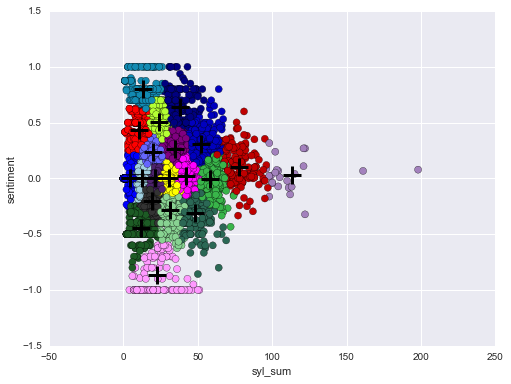

In [35]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster.syl_sum, df_cluster.sentiment, c=colors[df_cluster.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Create 3 clusters

In [36]:
df_cluster_3 = df_cluster

In [37]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,"Bistritz._--Left Munich at 8:35 P. M., on 1st ...",110,32,-0.066667,4
1,"Buda-Pesth seems a wonderful place, from the g...",108,29,0.406250,11
2,"I feared to go very far from the station, as w...",93,31,-0.017500,4
3,The impression I had was that we were leaving ...,174,55,0.483333,10
4,"We left in pretty good time, and came after ni...",57,17,0.316667,16


In [38]:
X = df_cluster_3.drop(0, axis=1)

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [41]:
df_cluster_3['cluster'] = km.labels_

In [42]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,53.891217,17.427881,0.047028
1,18.471812,5.975168,0.050301
2,128.725139,41.336319,0.052039


Create 3 Clusters with no syl_sum

In [43]:
df_cluster_no_syl = df_cluster

In [44]:
df_cluster_no_syl = df_cluster.drop('syl_sum', 1)

In [45]:
X = df_cluster_no_syl.drop(0, axis=1)

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [48]:
df_cluster_no_syl['cluster'] = km.labels_

In [49]:
df_cluster_no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,63.767768,0.523422
1,130.284057,0.011432
2,42.435400,-0.031309


Create 5 Clusters

In [50]:
df_cluster_5 = df_cluster

In [51]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment,cluster
0,"Bistritz._--Left Munich at 8:35 P. M., on 1st ...",110,32,-0.066667,2
1,"Buda-Pesth seems a wonderful place, from the g...",108,29,0.406250,2
2,"I feared to go very far from the station, as w...",93,31,-0.017500,2
3,The impression I had was that we were leaving ...,174,55,0.483333,2
4,"We left in pretty good time, and came after ni...",57,17,0.316667,0


In [52]:
X = df_cluster_5.drop(0, axis=1)

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [54]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [55]:
df_cluster_5['cluster'] = km.labels_

In [56]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,190.765240,61.127108,0.109869
1,15.367395,4.989860,-0.021885
2,53.221842,17.195084,-0.029295
3,59.692037,19.436768,0.539771
4,109.939485,35.297854,-0.002115


Find ideal amount of clusters for novel

Find Sentiment Pattern 

20 pieces

In [57]:
df_novel['total_char'].sum()

644972

In [58]:
ratio = (df_novel['total_char'].sum()/20) - 50

In [59]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - 100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [60]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:317]
df_novel['total_char'][317:667]
df_novel['total_char'][667:1108]
df_novel['total_char'][1108:1526]
df_novel['total_char'][1526:1907]
df_novel['total_char'][1907:2330]
df_novel['total_char'][2330:2850]
df_novel['total_char'][2850:3308]
df_novel['total_char'][3308:3723]
df_novel['total_char'][3723:4182]
df_novel['total_char'][4182:4652]
df_novel['total_char'][4652:5061]
df_novel['total_char'][5061:5457]
df_novel['total_char'][5457:5837]
df_novel['total_char'][5837:6303]
df_novel['total_char'][6303:6711]
df_novel['total_char'][6711:7160]
df_novel['total_char'][7160:7615]
df_novel['total_char'][7615:8042]
df_novel['total_char'][8042:8448]


In [61]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
317
0.0733002819269
317
667
0.0890205508683
667
1108
0.0441128848004
1108
1526
0.0837840524596
1526
1907
0.0339079651757
1907
2330
0.0557563643726
2330
2850
0.0613456653745
2850
3308
0.023363761471
3308
3723
0.0450529735826
3723
4182
0.0510201274674
4182
4652
0.0309906811175
4652
5061
0.0614957997721
5061
5457
0.0808180863165
5457
5837
0.0360736590912
5837
6303
-0.00816024154275
6303
6711
0.0438315689281
6711
7160
0.0615025587297
7160
7615
0.0610173401182
7615
8042
0.0477583208135
8042
8448
0.0323355755623


In [62]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.07330028  0.08902055  0.04411288  0.08378405  0.03390797  0.05575636
  0.06134567  0.02336376  0.04505297  0.05102013  0.03099068  0.0614958
  0.08081809  0.03607366 -0.00816024  0.04383157  0.06150256  0.06101734
  0.04775832  0.03233558]


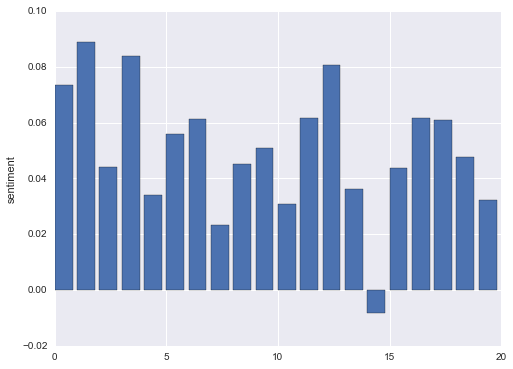

In [63]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern - need to fix this code for the three piece

In [64]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
8446,It is a _selected_ list; every book in it has ...,"[2, 2, 1, 8, 4, 5, 4, 2, 2, 3, 8, 1, 7, 7, 2, 7]",65,"[1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 3, 1, 2, 3, 1, 2]",25,0.257143
8447,The Grosset & Dunlap list is not only the grea...,"[3, 7, 6, 4, 2, 3, 4, 3, 8, 5, 2, 4, 7, 9, 2, ...",122,"[1, 2, 2, 1, 1, 1, 2, 1, 3, 2, 1, 1, 2, 3, 1, ...",42,0.358333
8448,It will pay you to _Look on t...,"[2, 4, 3, 3, 2, 4, 2, 3, 5, 4, 2, 3, 7, 2, 4, ...",161,"[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, ...",52,-0.028125
8449,Ask for Grosset & Dunlap's list THE SECRET O...,"[3, 3, 7, 6, 2, 4, 3, 6, 2, 3, 8, 3, 10, 7, 3,...",516,"[1, 1, 2, 2, 0, 1, 1, 2, 1, 1, 3, 1, 4, 4, 1, ...",161,0.066942
8450,{pg 165} It have told him=> She must have tol...,"[2, 3, 2, 4, 4, 3, 3, 4, 4, 4, 3, 2, 3, 4, 2, ...",281,"[0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, ...",78,0.000000


In [65]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) -100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [66]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:2683]
df_novel['total_char'][2683:5571]
df_novel['total_char'][5571:8451]


KeyboardInterrupt: 

In [67]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
2683
0.0629106791893
2683
5571
0.0476900524062
5571
8451
0.0388949610103


In [68]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.06291068  0.04769005  0.03889496]


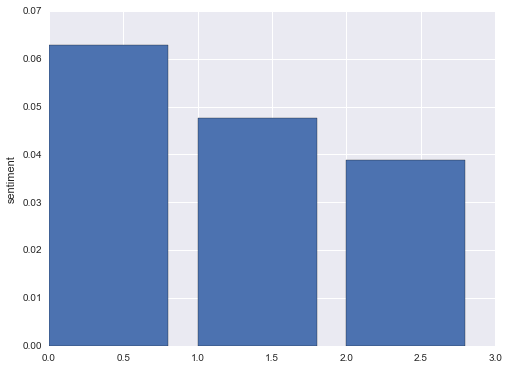

In [69]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

Create sentiment pattern based on ideal cluster numbers